In [1]:
import os
from typing import Dict, List, Union, Optional
from urllib.request import urlretrieve
import re

import contextily
import geopandas as gpd
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from shapely.geometry import Point
from scipy.spatial import cKDTree

%matplotlib inline

In [2]:
pd.options.display.max_columns = None
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import utils
import broadband_extract
import census_extract
import transpo_extract

In [4]:
state_lines_gdf = census_extract.extract_tiger_state_lines_2021()

In [5]:
state_lines_gdf.head(2)

,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,3,5,54,01779805,54,WV,West Virginia,00,G4000,A,62266298634,489204185,+38.6472854,-080.6183274,"POLYGON ((-80.85847 37.42831, -80.85856 37.428..."
1,3,5,12,00294478,12,FL,Florida,00,G4000,A,138961722096,45972570361,+28.3989775,-082.5143005,"MULTIPOLYGON (((-83.10874 24.62949, -83.10711 ..."


In [6]:
state_list = ["IL", "MI", "WI", "IN", "MN", "IA", "MO"]
region_gdf = state_lines_gdf.loc[state_lines_gdf["STUSPS"].isin(state_list)].copy()
region_gdf

,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
2,2,3,17,01779784,17,IL,Illinois,00,G4000,A,143778561906,6216493488,+40.1028754,-089.1526108,"POLYGON ((-89.17208 37.06831, -89.17296 37.067..."
3,2,4,27,00662849,27,MN,Minnesota,00,G4000,A,206232627084,18949394733,+46.3159573,-094.1996043,"POLYGON ((-92.74568 45.29604, -92.74629 45.295..."
15,2,3,55,01779806,55,WI,Wisconsin,00,G4000,A,140292321657,29343646672,+44.6309071,-089.7093916,"POLYGON ((-87.11901 43.19082, -87.10840 43.125..."
42,2,3,26,01779789,26,MI,Michigan,00,G4000,A,146614937132,103871870536,+44.8441768,-085.6604907,"POLYGON ((-82.72317 42.47778, -82.72602 42.474..."
45,2,4,29,01779791,29,MO,Missouri,00,G4000,A,178052333716,2487445715,+38.3507500,-092.4567826,"POLYGON ((-92.71460 40.58943, -92.71437 40.589..."
48,2,3,18,00448508,18,IN,Indiana,00,G4000,A,92789363558,1541248299,+39.9013136,-086.2919129,"POLYGON ((-86.32960 38.18180, -86.33037 38.182..."
54,2,4,19,01779785,19,IA,Iowa,00,G4000,A,144659721012,1085964740,+42.0700243,-093.4933473,"POLYGON ((-91.61083 43.50066, -91.61043 43.500..."


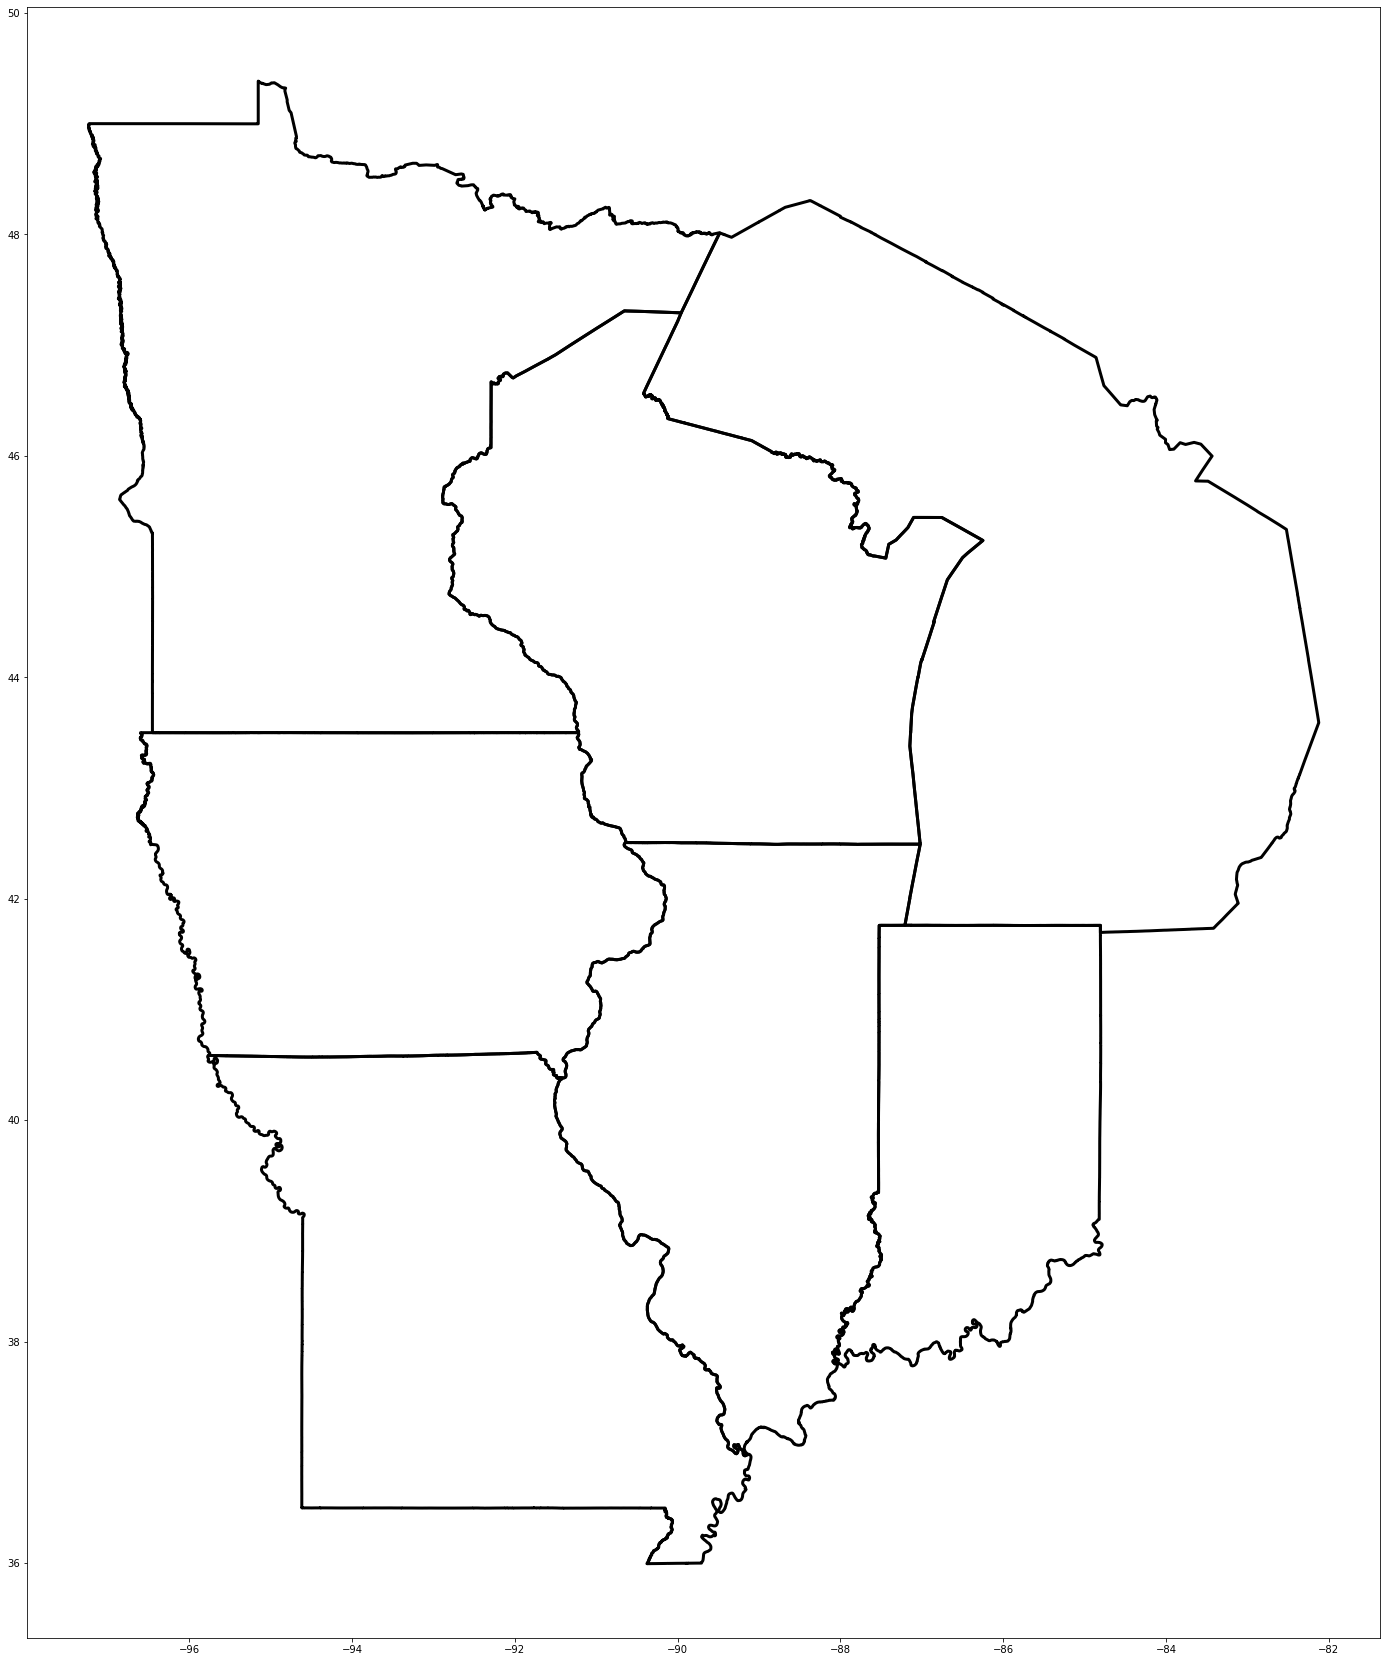

In [7]:
fig, ax = plt.subplots(figsize=(30,30))

ax = region_gdf.plot(color="none", linewidth=3, edgecolor="black", ax=ax)

In [8]:
county_lines_gdf = census_extract.extract_tiger_county_lines_2021()

In [9]:
county_lines_gdf.head(2)

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,31,039,00835841,31039,Cuming,Cuming County,06,H1,G4020,None,None,None,A,1477645345,10690204,+41.9158651,-096.7885168,"POLYGON ((-96.55515 41.91587, -96.55515 41.914..."
1,53,069,01513275,53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,None,None,A,680976231,61568965,+46.2946377,-123.4244583,"POLYGON ((-123.49077 46.38358, -123.48813 46.3..."


In [10]:
state_fips = ["17", "18", "19", "26", "27", "29", "55"]
state_counties_gdf = county_lines_gdf.loc[county_lines_gdf["STATEFP"].isin(state_fips)].copy()

In [11]:
state_counties_gdf.head(2)

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
16,55,111,01581115,55111,Sauk,Sauk County,06,H1,G4020,357,12660,None,A,2153686013,45692969,+43.4280010,-089.9433184,"POLYGON ((-89.83829 43.20592, -89.83916 43.205..."
21,29,083,00758496,29083,Henry,Henry County,06,H1,G4020,None,None,None,A,1805054746,91657543,+38.3864909,-093.7926278,"POLYGON ((-93.51565 38.37395, -93.51565 38.373..."


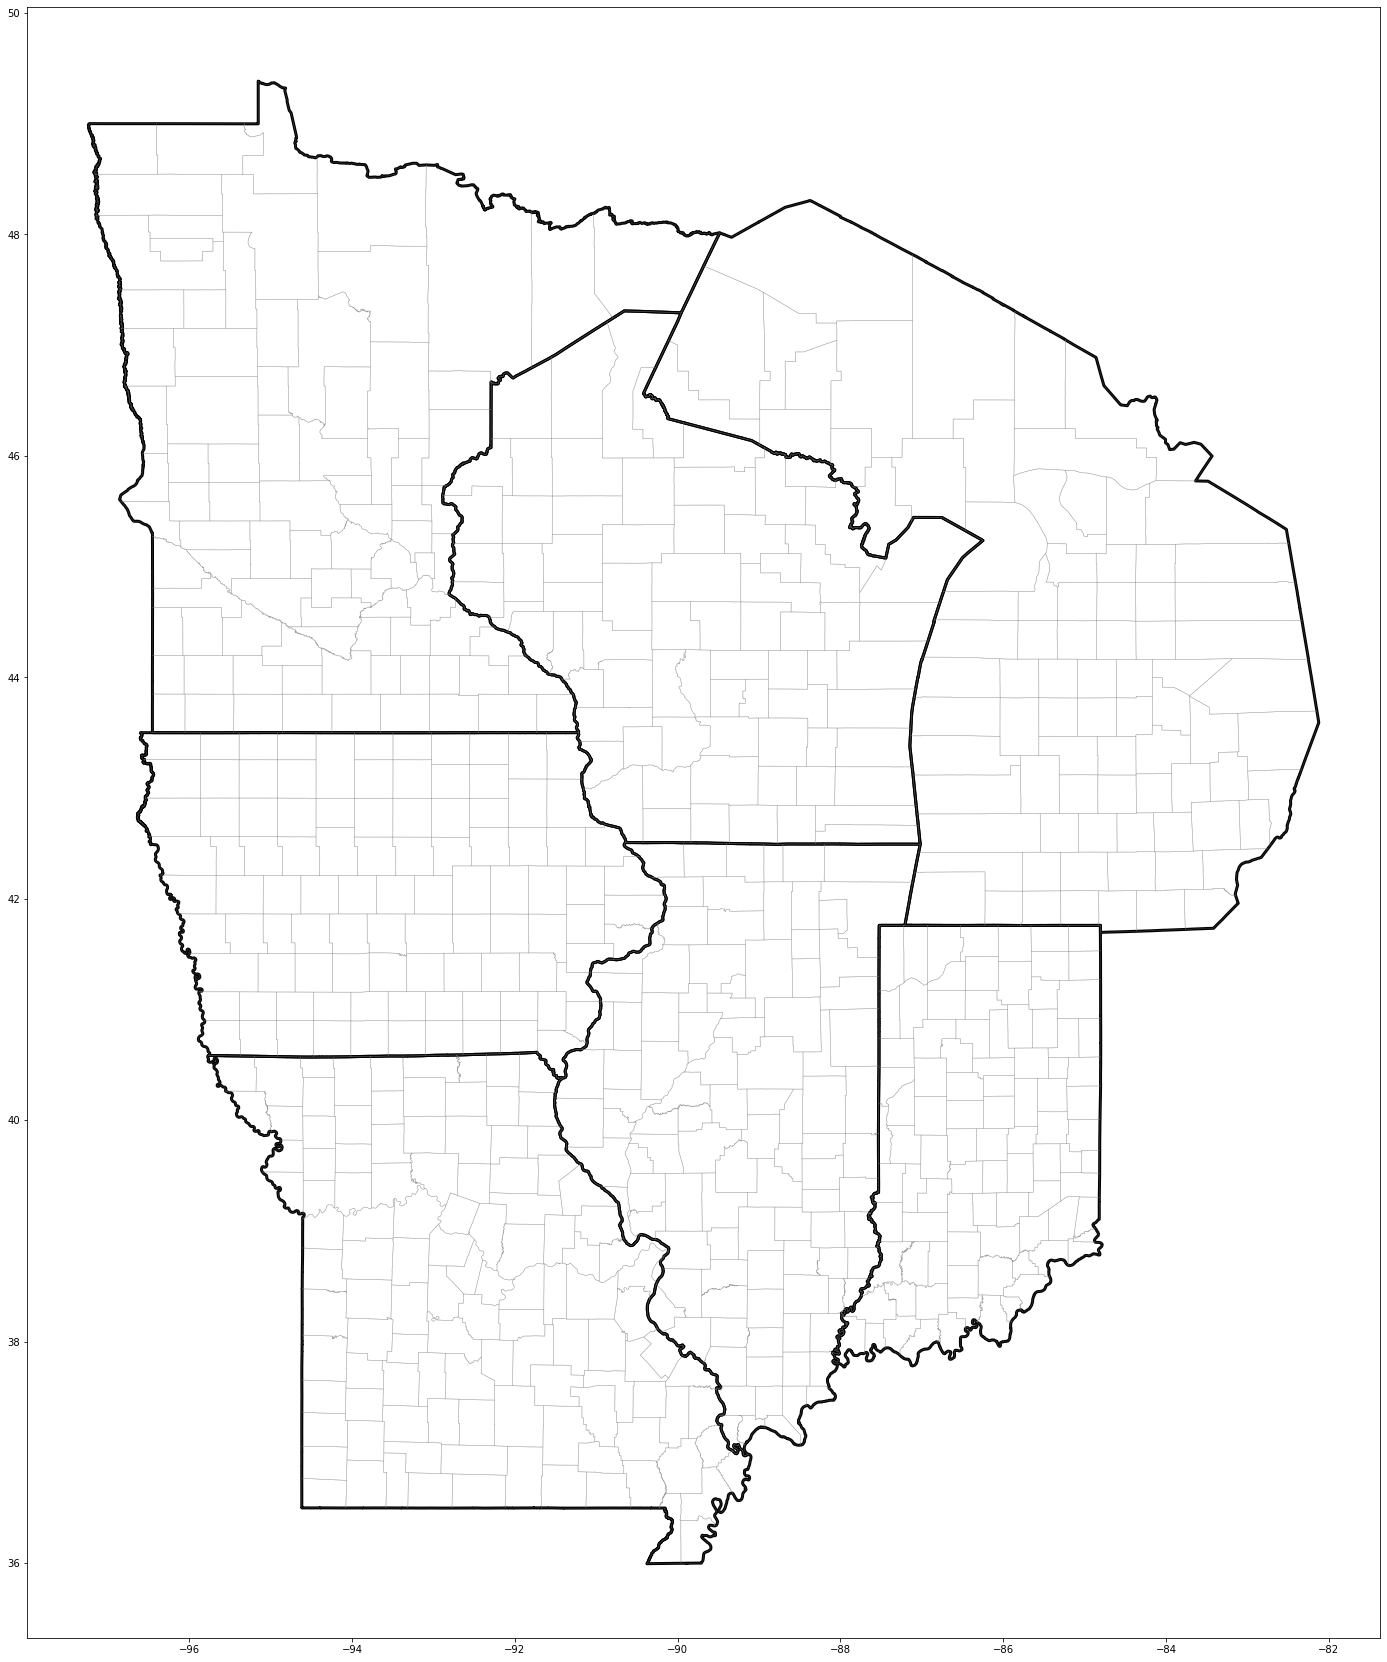

In [12]:
fig, ax = plt.subplots(figsize=(30,30))

ax = region_gdf.plot(color="none", linewidth=3, edgecolor="black", ax=ax)
ax = state_counties_gdf.plot(color="none", linewidth=0.5, edgecolor="grey", alpha=0.5, ax=ax)

In [13]:
amtrack_rails_gdf = transpo_extract.extract_amtrak_routes()
amtrack_rails_gdf = amtrack_rails_gdf.to_crs(state_counties_gdf.crs)
amtrack_in_region_gdf = amtrack_rails_gdf.overlay(state_counties_gdf, how="intersection")

In [14]:
amtrack_in_region_gdf.head(2)

,OBJECTID,NAME_1,Shape_Leng,Shape_Le_1,ShapeSTLength,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME_2,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,4,Blue Water,5.114384e+05,5.114384e+05,6.939225e+05,18,089,00450495,18089,Lake,Lake County,06,H1,G4020,176,16980,23844,A,1291957607,331002858,+41.4722470,-087.3743368,"LINESTRING (-87.52443 41.70420, -87.52396 41.7..."
1,6,Capitol Limited,1.287416e+06,1.287416e+06,1.703070e+06,18,089,00450495,18089,Lake,Lake County,06,H1,G4020,176,16980,23844,A,1291957607,331002858,+41.4722470,-087.3743368,"LINESTRING (-87.52443 41.70420, -87.52396 41.7..."


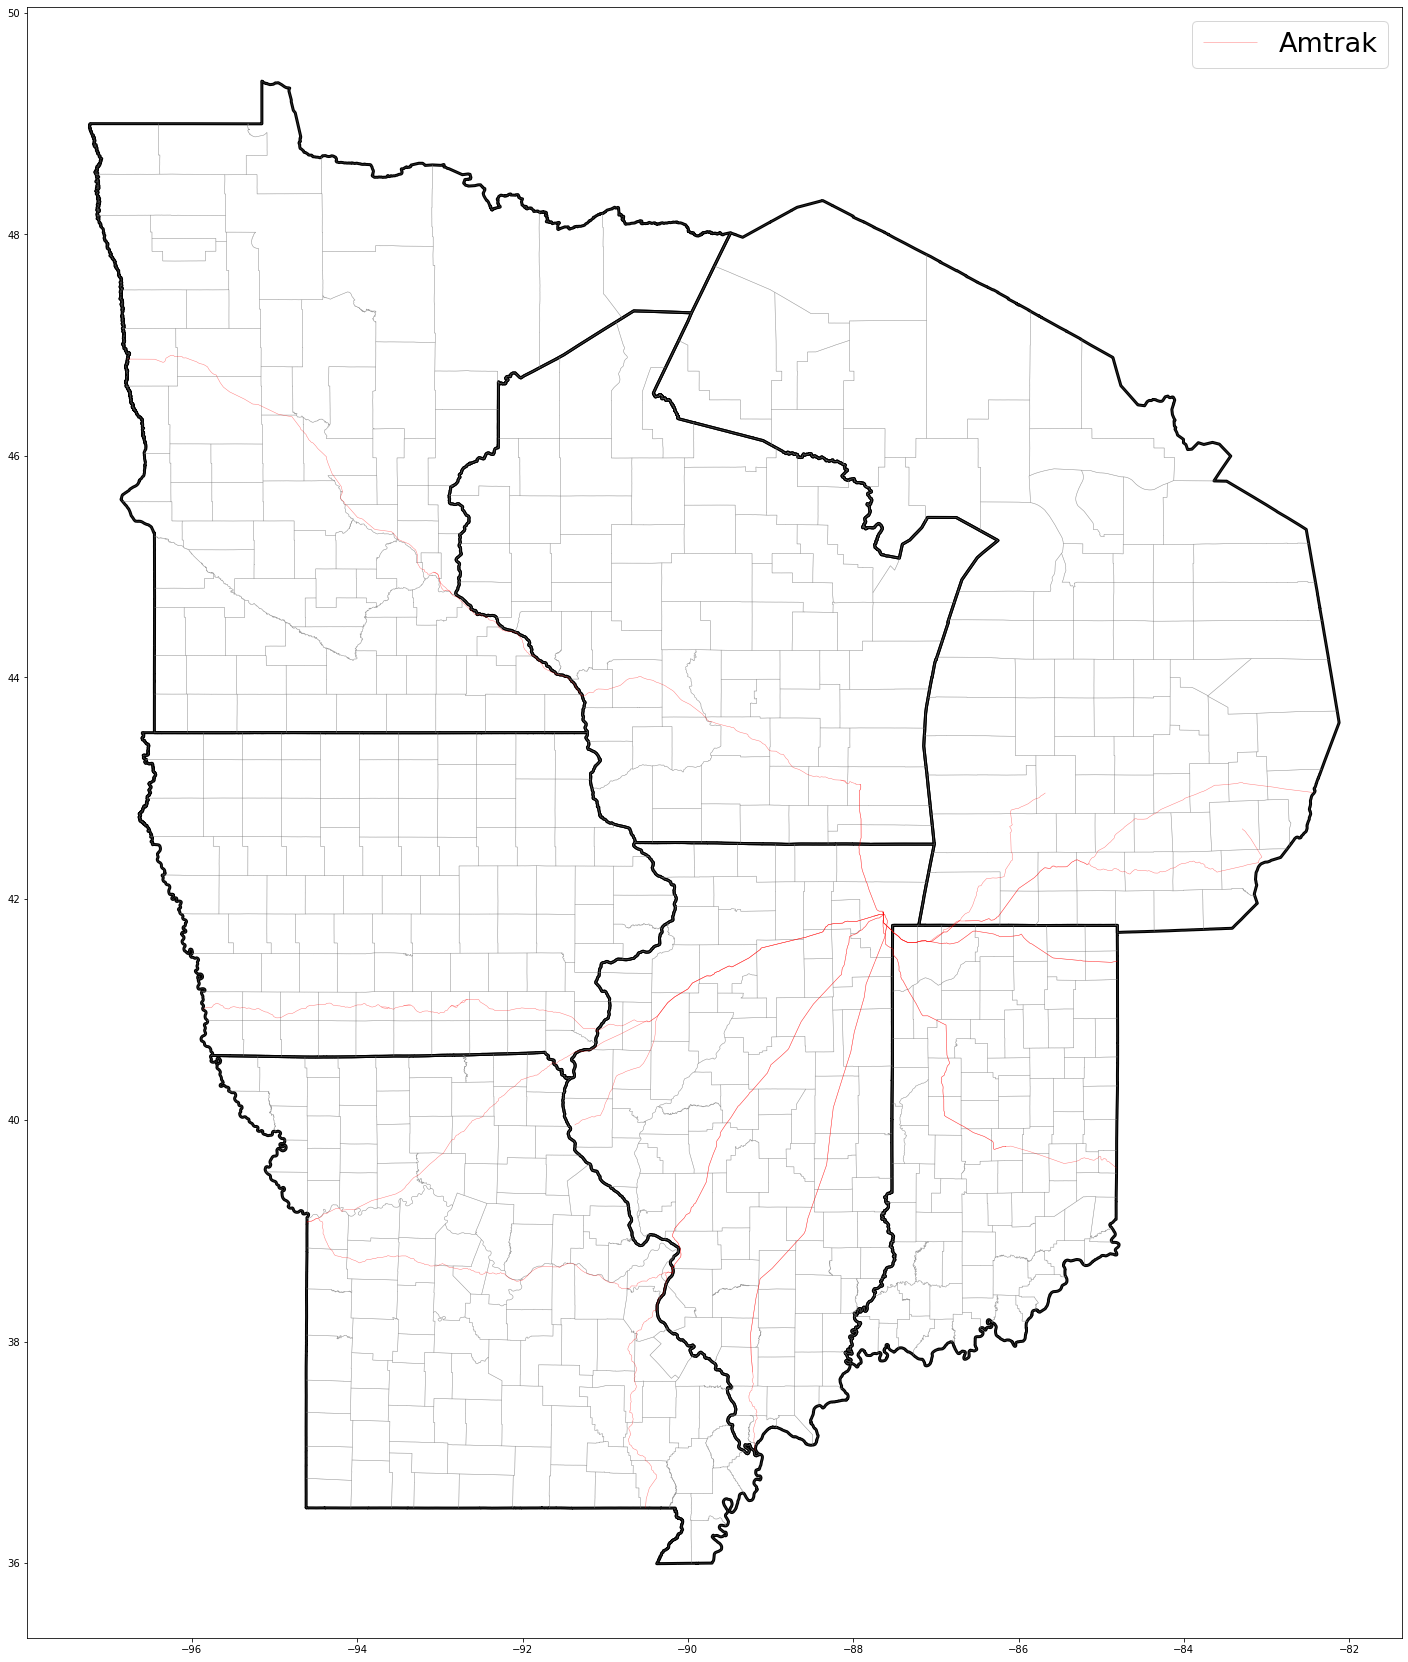

In [15]:
fig_width=30
fig, ax = plt.subplots(figsize=(fig_width,fig_width))

ax = region_gdf.plot(color="none", linewidth=3, edgecolor="black", ax=ax)
ax = state_counties_gdf.plot(color="none", linewidth=0.5, edgecolor="grey", alpha=0.5, ax=ax)
ax = amtrack_in_region_gdf.plot(linewidth=0.5, color="red", alpha=0.5, ax=ax, label="Amtrak")
ax.legend(fontsize=fig_width*0.9)

In [44]:
broadband_gdf = broadband_extract.extract_fcc_broadband_area_coverage_12_2020()

/home/matt/projects/analysis/this_land/code/broadband_extract.py:48: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  return extract_csv_from_url(file_path=file_path, url=url, return_df=return_df)


In [45]:
broadband_gdf.head(2)

,type,id,tech,urban_rural,tribal_non,speed,has_0,has_1,has_2,has_3more
0,place,100100,acfosw,R,N,0.2,0,0,0,193
1,place,100124,acfosw,R,N,0.2,0,0,0,2639


In [46]:
broadband_gdf.shape

(23809149, 10)

In [17]:
tiger_rail_lines_gdf = census_extract.extract_tiger_rail_lines_2021()

In [20]:
rail_in_region_gdf = tiger_rail_lines_gdf.overlay(state_counties_gdf, how="intersection")

/home/matt/miniconda3/envs/geo_env/lib/python3.9/site-packages/geopandas/geodataframe.py:2196: UserWarning: `keep_geom_type=True` in overlay resulted in 3417 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  return geopandas.overlay(


In [21]:
rail_in_region_gdf.head(2)

,LINEARID,FULLNAME,MTFCC_1,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC_2,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,11083630585,at and Sf Rlwy,R1011,29,045,00758477,29045,Clark,Clark County,06,H1,G4020,161,22800,None,A,1306924727,18695976,+40.4072747,-091.7294720,"LINESTRING (-91.62176 40.51822, -91.62299 40.5..."
1,11083630719,Burlington Northern RR,R1011,29,045,00758477,29045,Clark,Clark County,06,H1,G4020,161,22800,None,A,1306924727,18695976,+40.4072747,-091.7294720,"LINESTRING (-91.49682 40.27750, -91.49695 40.2..."


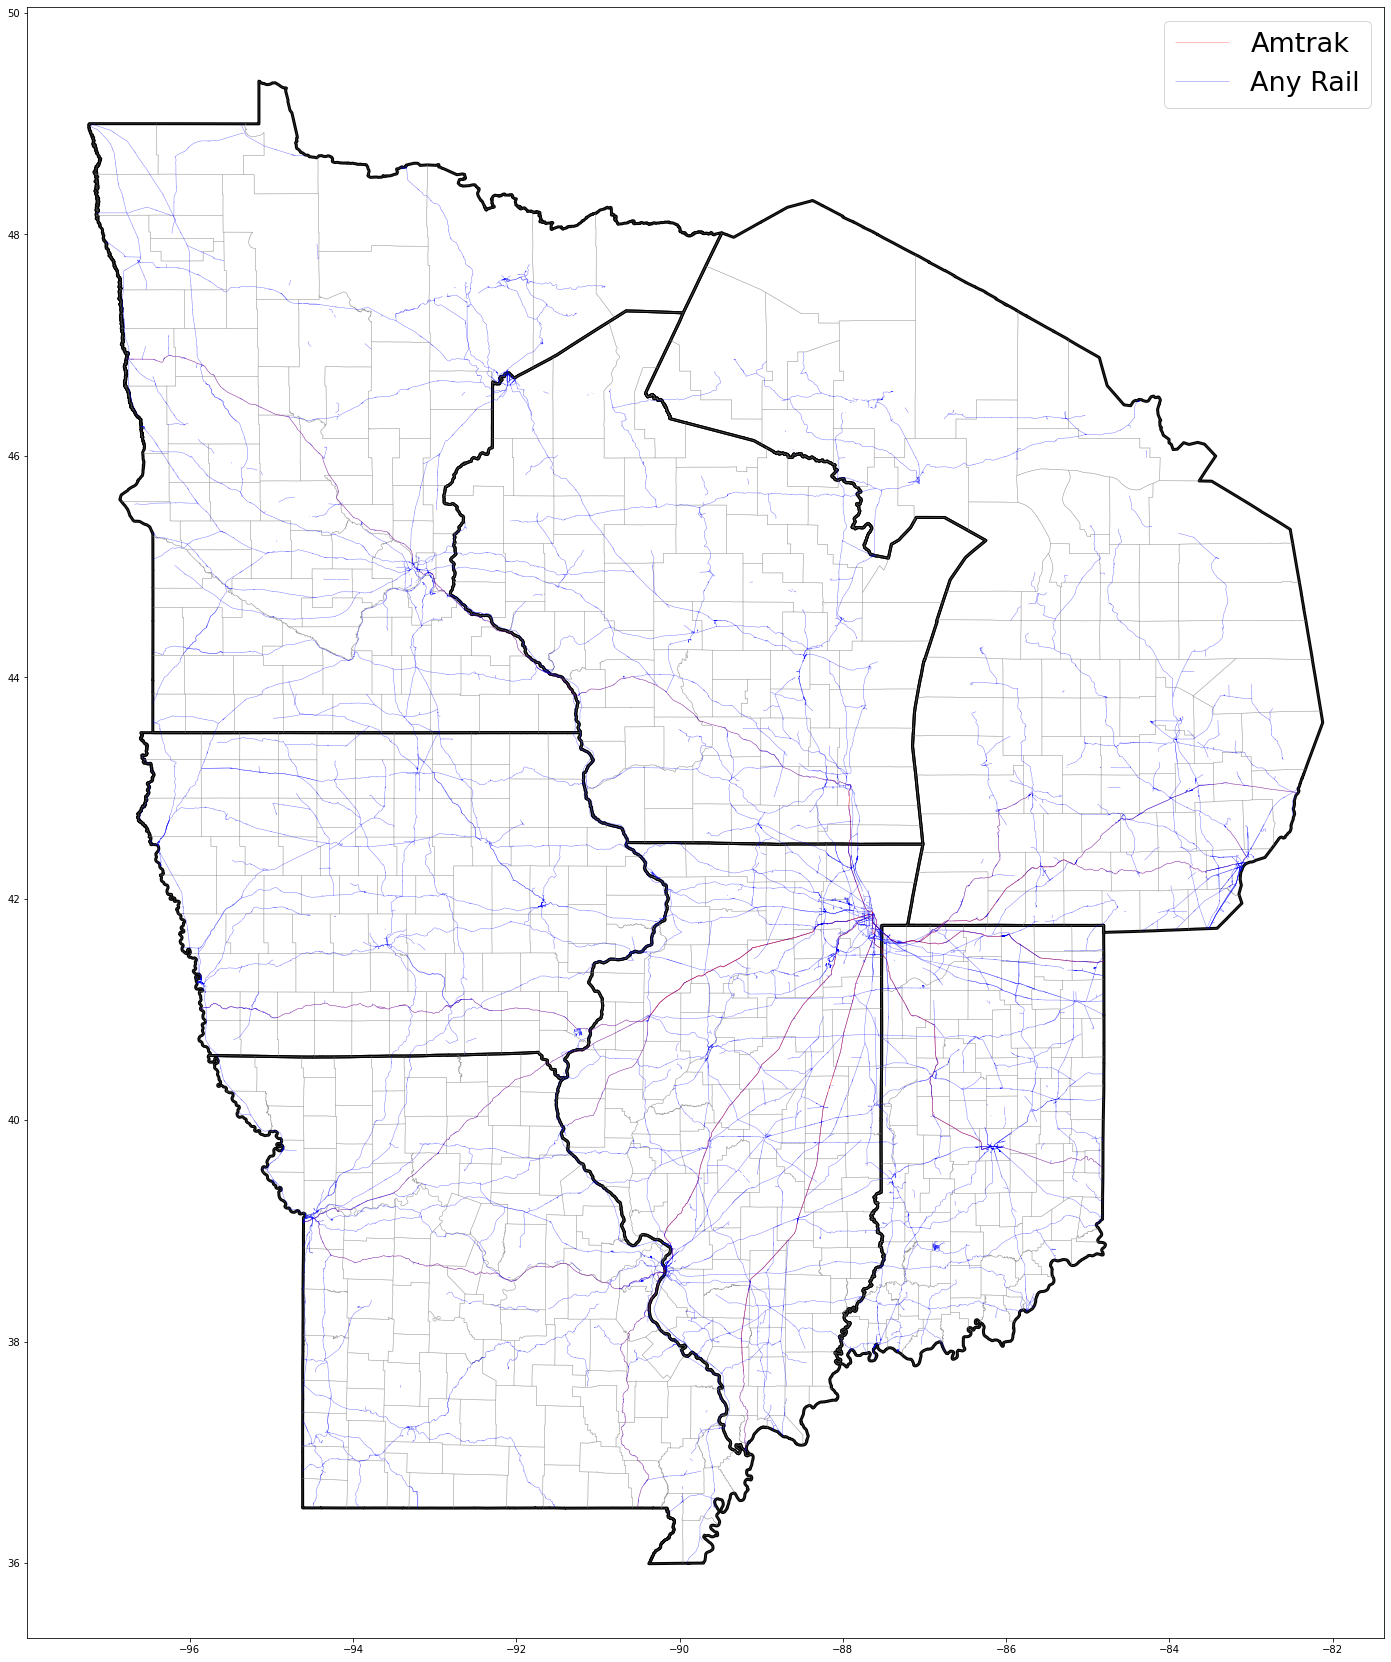

In [22]:
fig_width=30
fig, ax = plt.subplots(figsize=(fig_width,fig_width))

ax = region_gdf.plot(color="none", linewidth=3, edgecolor="black", ax=ax)
ax = state_counties_gdf.plot(color="none", linewidth=0.5, edgecolor="grey", alpha=0.5, ax=ax)
ax = amtrack_in_region_gdf.plot(linewidth=0.5, color="red", alpha=0.5, ax=ax, label="Amtrak")
ax = rail_in_region_gdf.plot(linewidth=0.5, color="blue", alpha=0.5, ax=ax, label="Any Rail")
ax.legend(fontsize=fig_width*0.9)